In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_hits = pd.read_csv("additional/hits_dataset.csv", delimiter="\t")
df_hits["hit"] = 1
df_hits

,song_id,song_name,id_artists,name_artists,popularity,explicit,song_type,track_number,num_artists,num_available_markets,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,hit
0,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next",['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],87,True,Solo,11,1,79,...,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,1
1,5p7ujcrUXASCNwRaWNHR1C,Without Me,['26VFTg2z8YR0cCuwLzESi2'],['Halsey'],87,True,Solo,1,1,79,...,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,1
2,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,['0Y5tJX1MQlPlqiwlOH1tJY'],['Travis Scott'],86,True,Solo,3,1,79,...,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,1
3,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,"['246dkjvS1zLTtiykXe5h60', '1zNqQNIdeOUZHb8zbZ...","['Post Malone', 'Swae Lee']",92,False,Collaboration,2,2,79,...,0.55600,0.760,0.479,0.000000,0.0703,-5.574,0.0466,0.913,89.911,1
4,1rqqCSm0Qe4I9rUvWncaom,High Hopes,['20JZFwl6HVl6yg8a4H3ZqK'],['Panic! At The Disco'],86,False,Solo,4,1,78,...,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11954,5mz9pQZZXNpAw9CdQ7Bk8q,Don't Pity Me - Mono; 2003 Remaster,['6lHC2EQMEMZiEmSfFloarn'],['Peter And Gordon'],8,False,Solo,1,1,78,...,0.61900,0.500,0.654,0.000000,0.3320,-8.633,0.0394,0.403,107.326,1
11955,2H9CKpZiLDF223BbwehpDF,Hush Hush; Hush Hush - Main,['6wPhSqRtPu1UhRCDX5yaDJ'],['The Pussycat Dolls'],57,False,Solo,1,1,59,...,0.10500,0.609,0.790,0.000000,0.3140,-3.787,0.0663,0.664,129.334,1
11956,7zqM7Wm2xJLZ50qAnTLoHD,"Lions, Tigers & Bears",['7gSjFKpVmDgC2MMsnN8CYq'],['Jazmine Sullivan'],49,False,Solo,4,1,71,...,0.07880,0.576,0.515,0.000000,0.1180,-6.178,0.0295,0.407,95.406,1
11957,4DPlKVZ6R1EHLfnIsy9ouh,The Weight,"['0rXI0q8Cahq6numvPlloaq', '3RwQ26hR2tJtA8F9p2...","['Diana Ross & The Supremes', 'The Temptations']",2,False,Collaboration,23,2,79,...,0.37000,0.566,0.607,0.000000,0.6710,-7.532,0.0357,0.765,91.378,1


In [2]:
df_nonhits = pd.read_csv("additional/nonhits_dataset.csv", delimiter="\t")
df_nonhits["hit"] = 0
df_nonhits

C:\Users\lasse\AppData\Local\Temp\ipykernel_19420\2533836516.py:1: DtypeWarning: Columns (11,12,13,14,15,16,17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nonhits = pd.read_csv("additional/nonhits_dataset.csv", delimiter="\t")


,song_id,song_name,id_artists,name_artists,popularity,explicit,song_type,track_number,num_artists,num_available_markets,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,hit
0,1TEL6MlSSVLSdhOSddidlJ,needy,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],76,True,Solo,2,1,79,...,0.78,0.647,0.309,7.41e-06,0.202,-7.948,0.0366,0.195,87.045,0
1,4uTvPEr01pjTbZgl7jcKBD,NASA,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],76,False,Solo,3,1,79,...,0.451,0.747,0.458,0,0.252,-6.891,0.303,0.47,75.029,0
2,2hloaUoRonYssMuqLCBLTX,bloodline,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],74,True,Solo,4,1,79,...,0.0815,0.758,0.665,0.000157,0.216,-5.188,0.0774,0.643,151.976,0
3,3wFLWP0FcIqHK1wb1CPthQ,fake smile,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],73,True,Solo,5,1,79,...,0.329,0.45,0.619,0,0.319,-7.412,0.372,0.427,83.3,0
4,5Il6Oe7lr5XM7A0cWbVQtr,bad idea,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],74,False,Solo,6,1,79,...,0.0268,0.847,0.579,0.0545,0.102,-5.314,0.0719,0.569,137.998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899063,2tP0ryZParpdjvxubgXhTN,Love Is Here to Stay,"['3Dzj993UEz8Z5ovxuirzFO', '6RCsx4p5smZHYz2P5H...","['Lindsey Buckingham', 'Christine McVie']",16,False,Collaboration,5,2,1,...,0.366,0.446,0.658,2.49e-05,0.751,-8.362,0.0297,0.554,84.74,0
899064,7Ltni80U0w7bmYjXPNzSEa,Heinlein's Planet,['4urvwbid7NFoVes5PTx9lV'],['Tony Carey'],0,False,Solo,5,1,79,...,0.481,0.305,0.456,0.933,0.111,-20.199,0.0634,0.171,96.996,0
899065,1gQClXN1Dq4rj0wBzddcNA,Beds are Burning - Karaoke Lead Vocal Version,['7yv4DJOCmilSbxxsdQgXWk'],['Pictomusic'],0,False,Solo,2,1,79,...,0.0118,0.852,0.648,0,0.0503,-7.189,0.048,0.559,120.15,0
899066,2jhxQrFNdVPkWL28X7ZpeK,Un homme heureux - Version karaoké instrumentale,['7yv4DJOCmilSbxxsdQgXWk'],['Pictomusic'],0,False,Solo,1,1,79,...,0.973,0.664,0.353,0.787,0.0878,-12.303,0.0693,0.284,116.45,0


In [3]:
combined_df = pd.concat([df_hits, df_nonhits], axis=0)
combined_df.replace("-", float("nan"), inplace=True)
# Drop all rows with NaN values
combined_df

,song_id,song_name,id_artists,name_artists,popularity,explicit,song_type,track_number,num_artists,num_available_markets,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,hit
0,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next",['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],87,True,Solo,11,1,79,...,0.229,0.717,0.653,0.0,0.101,-5.634,0.0658,0.412,106.966,1
1,5p7ujcrUXASCNwRaWNHR1C,Without Me,['26VFTg2z8YR0cCuwLzESi2'],['Halsey'],87,True,Solo,1,1,79,...,0.297,0.752,0.488,0.000009,0.0936,-7.05,0.0705,0.533,136.041,1
2,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,['0Y5tJX1MQlPlqiwlOH1tJY'],['Travis Scott'],86,True,Solo,3,1,79,...,0.00513,0.834,0.73,0.0,0.124,-3.714,0.222,0.446,155.008,1
3,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,"['246dkjvS1zLTtiykXe5h60', '1zNqQNIdeOUZHb8zbZ...","['Post Malone', 'Swae Lee']",92,False,Collaboration,2,2,79,...,0.556,0.76,0.479,0.0,0.0703,-5.574,0.0466,0.913,89.911,1
4,1rqqCSm0Qe4I9rUvWncaom,High Hopes,['20JZFwl6HVl6yg8a4H3ZqK'],['Panic! At The Disco'],86,False,Solo,4,1,78,...,0.193,0.579,0.904,0.0,0.064,-2.729,0.0618,0.681,82.014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899063,2tP0ryZParpdjvxubgXhTN,Love Is Here to Stay,"['3Dzj993UEz8Z5ovxuirzFO', '6RCsx4p5smZHYz2P5H...","['Lindsey Buckingham', 'Christine McVie']",16,False,Collaboration,5,2,1,...,0.366,0.446,0.658,2.49e-05,0.751,-8.362,0.0297,0.554,84.74,0
899064,7Ltni80U0w7bmYjXPNzSEa,Heinlein's Planet,['4urvwbid7NFoVes5PTx9lV'],['Tony Carey'],0,False,Solo,5,1,79,...,0.481,0.305,0.456,0.933,0.111,-20.199,0.0634,0.171,96.996,0
899065,1gQClXN1Dq4rj0wBzddcNA,Beds are Burning - Karaoke Lead Vocal Version,['7yv4DJOCmilSbxxsdQgXWk'],['Pictomusic'],0,False,Solo,2,1,79,...,0.0118,0.852,0.648,0,0.0503,-7.189,0.048,0.559,120.15,0
899066,2jhxQrFNdVPkWL28X7ZpeK,Un homme heureux - Version karaoké instrumentale,['7yv4DJOCmilSbxxsdQgXWk'],['Pictomusic'],0,False,Solo,1,1,79,...,0.973,0.664,0.353,0.787,0.0878,-12.303,0.0693,0.284,116.45,0


In [4]:
# Check for NaN values in all columns
nan_columns = combined_df.columns[combined_df.isna().any()].tolist()

# Print columns with NaN values
print("Columns with NaN values:")
print(nan_columns)


Columns with NaN values:
['duration_ms', 'key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']


In [5]:
from sklearn.impute import SimpleImputer

combined_df.replace("-", float("nan"), inplace=True)   ## evtl hier schon mean replacement???
# combined_df.dropna(inplace=True)   # drop nan value rows
#Fill missing values with mean for each numeric attribute
imputer = SimpleImputer(strategy='mean')
for col in nan_columns:
    combined_df[col] = imputer.fit_transform(combined_df[[col]])

combined_df

,song_id,song_name,id_artists,name_artists,popularity,explicit,song_type,track_number,num_artists,num_available_markets,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,hit
0,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next",['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],87,True,Solo,11,1,79,...,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,1
1,5p7ujcrUXASCNwRaWNHR1C,Without Me,['26VFTg2z8YR0cCuwLzESi2'],['Halsey'],87,True,Solo,1,1,79,...,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,1
2,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,['0Y5tJX1MQlPlqiwlOH1tJY'],['Travis Scott'],86,True,Solo,3,1,79,...,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,1
3,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,"['246dkjvS1zLTtiykXe5h60', '1zNqQNIdeOUZHb8zbZ...","['Post Malone', 'Swae Lee']",92,False,Collaboration,2,2,79,...,0.55600,0.760,0.479,0.000000,0.0703,-5.574,0.0466,0.913,89.911,1
4,1rqqCSm0Qe4I9rUvWncaom,High Hopes,['20JZFwl6HVl6yg8a4H3ZqK'],['Panic! At The Disco'],86,False,Solo,4,1,78,...,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899063,2tP0ryZParpdjvxubgXhTN,Love Is Here to Stay,"['3Dzj993UEz8Z5ovxuirzFO', '6RCsx4p5smZHYz2P5H...","['Lindsey Buckingham', 'Christine McVie']",16,False,Collaboration,5,2,1,...,0.36600,0.446,0.658,0.000025,0.7510,-8.362,0.0297,0.554,84.740,0
899064,7Ltni80U0w7bmYjXPNzSEa,Heinlein's Planet,['4urvwbid7NFoVes5PTx9lV'],['Tony Carey'],0,False,Solo,5,1,79,...,0.48100,0.305,0.456,0.933000,0.1110,-20.199,0.0634,0.171,96.996,0
899065,1gQClXN1Dq4rj0wBzddcNA,Beds are Burning - Karaoke Lead Vocal Version,['7yv4DJOCmilSbxxsdQgXWk'],['Pictomusic'],0,False,Solo,2,1,79,...,0.01180,0.852,0.648,0.000000,0.0503,-7.189,0.0480,0.559,120.150,0
899066,2jhxQrFNdVPkWL28X7ZpeK,Un homme heureux - Version karaoké instrumentale,['7yv4DJOCmilSbxxsdQgXWk'],['Pictomusic'],0,False,Solo,1,1,79,...,0.97300,0.664,0.353,0.787000,0.0878,-12.303,0.0693,0.284,116.450,0


In [6]:
# Check for NaN values in all columns
nan_columns = combined_df.columns[combined_df.isna().any()].tolist()

# Print columns with NaN values
print("Columns with NaN values:")
print(nan_columns)


Columns with NaN values:
[]


In [7]:
from sklearn.model_selection import train_test_split
combined_df['date'] = pd.to_datetime(combined_df['release_date'])
combined_df.sort_values(by="date", inplace=True)
border_day = combined_df["date"].iloc[-1]  - pd.DateOffset(years=6)
combined_df = combined_df[(combined_df["date"] >= border_day)]

split_day = combined_df["date"].iloc[-1]  - pd.DateOffset(years=1)
train_df = combined_df[(combined_df["date"]  < split_day)]
test_df = combined_df[(combined_df["date"]  >= split_day)]
#train_df, test_df = train_test_split(combined_df, test_size=1/6, shuffle=False)

In [8]:
combined_df

,song_id,song_name,id_artists,name_artists,popularity,explicit,song_type,track_number,num_artists,num_available_markets,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,hit,date
846000,3rTIDlmlGskGnRRqmRtvYn,Lone Stranger,['1W006EgE9fkSO9CpTnVlqN'],['James Dooley'],0,False,Solo,19,1,74,...,0.235,0.199,0.896000,0.1110,-15.446,0.0329,0.0476,69.245,0,2013-08-26
604826,7zhdgvEuhcxy4iwc0ssoty,Ghost of Gloria Goodchild,['3F2Y683ovlWT53WKCeq0oj'],['Goodie Mob'],5,True,Solo,9,1,2,...,0.609,0.612,0.000000,0.4980,-7.317,0.1240,0.3850,140.953,0,2013-08-26
604827,7urrpTy9j5QGMYrZpPwuEy,Kolors,['3F2Y683ovlWT53WKCeq0oj'],['Goodie Mob'],12,True,Solo,10,1,2,...,0.482,0.722,0.000000,0.5020,-7.968,0.3140,0.4840,105.123,0,2013-08-26
604828,6Ppgg7vDhYoyyNmmfIE9zK,Come as You Are,['3F2Y683ovlWT53WKCeq0oj'],['Goodie Mob'],5,True,Solo,11,1,2,...,0.656,0.952,0.000582,0.0455,-5.103,0.0602,0.4760,130.923,0,2013-08-26
604829,3EOsorrvvIhtlTOoMdEshm,Nexperience,['3F2Y683ovlWT53WKCeq0oj'],['Goodie Mob'],5,True,Solo,12,1,2,...,0.610,0.798,0.000660,0.5230,-6.880,0.2730,0.6130,138.103,0,2013-08-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098,0xAqhyWvTkfcdFgm7dozMO,(I Wanna) Testify (Mono Single Version),['1Ve5PoI7i5jIIP1xudo6AB'],['The Parliaments'],7,False,Solo,10,1,79,...,0.668,0.702,0.000000,0.0521,-5.750,0.0330,0.7540,105.227,1,2019-08-23
10903,6zhg8TnVKi90ITDzFKwPr0,Swingtown - Alternate Version,['6QtGlUje9TIkLrgPZrESuk'],['Steve Miller Band'],26,False,Solo,5,1,79,...,0.459,0.764,0.000544,0.2440,-6.662,0.0354,0.4390,124.557,1,2019-08-23
5856,2GvkFSjRXV0Ii3uYnHiQ74,Take My Advice,['40PLSl99xXqAQsCQQPmfyM'],['Kym Sims'],0,False,Solo,10,1,73,...,0.737,0.814,0.392000,0.0844,-10.396,0.0307,0.8030,120.010,1,2019-08-23
5080,0lej8CemYKkWVHg77Xe1ky,A Man Holdin' on (To a Woman Lettin’ Go),"['1Fj0R2t4HaJa3oUe8azB8R', '5LDnSV99gbDSsMX3Dc...","['Ty Herndon', 'Anita Cochran']",14,False,Collaboration,7,2,79,...,0.611,0.429,0.000014,0.1120,-8.619,0.0298,0.2370,128.007,1,2019-08-23


In [9]:
# Specify the columns
columns = ['artist_id', 'artist_name']

# Initialize an empty DataFrame
df_artists_train = pd.DataFrame(columns={col: [] for col in columns})

count = 0
artist_set = set()

for _, row in train_df.iterrows():
    current_artist_id_list = eval(row["id_artists"])
    current_artist_name_list = eval(row["name_artists"])
    for cur_art_id, cur_art_name in zip(current_artist_id_list, current_artist_name_list):
        if cur_art_id not in artist_set:
            artist_set.add(cur_art_id)
            df_artists_train.loc[len(df_artists_train)] = [cur_art_id, cur_art_name]
            count += 1

print("amount of artists:", count)
df_artists_train

amount of artists: 13284


,artist_id,artist_name
0,1W006EgE9fkSO9CpTnVlqN,James Dooley
1,3F2Y683ovlWT53WKCeq0oj,Goodie Mob
2,5xTn6i6eK7dFP98OaOFyBn,Big Fraze
3,4PzJueOuOBjr0qVlS3RU6w,Christopher Lewis
4,4eJWDgfm1In7unvUTB1DtE,V
...,...,...
13279,7gx7lqo98LuOGE0y8ATrRr,On the Town Orchestra
13280,5UvGRahK1OytDXGTzdf6hV,Humphrey Burton
13281,0MIlVcFgL7pDFqaZRmYDeE,Weiss
13282,2iG0HNCECG2DxXxSUcMhEX,Naxxos


In [10]:
import networkx as nx

all_artist_ids = artist_set.copy()

G = nx.Graph()

for id_art_cur in all_artist_ids:
    artist_name = df_artists_train[(df_artists_train["artist_id"] == id_art_cur)]["artist_name"]
    artist_info = df_artists_train[df_artists_train["artist_id"] == id_art_cur]
    if not artist_info.empty:  # Check if artist info exists
        # Filter out artists who are not successful
        node_attrs = {"name": artist_name.iloc[0]}
        G.add_node(id_art_cur, **node_attrs)
    else:
        print("Artist info not found for ID:", id_art_cur)

for _, row in train_df.iterrows():
    artist_ids = list(eval(row["id_artists"]))
    artist_names = list(eval(row["name_artists"]))
    # Filter out songs that do not have more than one artist in their execution
    if len(artist_ids) > 1:
        for i in range(len(artist_ids)):
            for j in range(i+1, len(artist_ids)):
                artist_id_1 = str(artist_ids[i])
                lable1 = str(artist_names[i])
                artist_id_2 = str(artist_ids[j])
                lable2 = str(artist_names[j])
                # Check if the edge already exists
                if G.has_edge(artist_id_1, artist_id_2):
                    # If the edge already exists, increment the weight by 1
                    G[artist_id_1][artist_id_2]['weight'] += 2
                else:
                    # Add a new edge with weight 1
                    G.add_edge(artist_id_1, artist_id_2, lable1=lable1, lable2=lable2, weight=2, song_id=str(row["song_id"]), song_name=str(row["song_name"]), explicit=bool(row["explicit"]), song_type=str(row["song_type"]), track_number=int(row["track_number"]), num_artists=int(row["num_artists"]), num_available_markets=int(row["num_available_markets"]), duration_ms=int(row["duration_ms"]), popularity=int(row["popularity"]), release_date=str(row["release_date"]), key = int(row["key"]), mode = int(row["mode"]), time_signature = int(row["time_signature"]), acousticness = float(row["acousticness"]), danceability = float(row["danceability"]), energy = float(row["energy"]), instrumentalness = float(row["instrumentalness"]), liveness = float(row["liveness"]),loudness = float(row["loudness"]), speechiness = float(row["speechiness"]), valence = float(row["valence"]), tempo = float(row["tempo"]))
        """else:
            #prüfe ob die Artists Teil der Interessanten Menge sind
            artist_id_1 = str(artist_ids[0])
            lable1 = str(artist_names[0])
            if not G.has_node(artist_id_1):
                node_attrs = {"name": lable1}
                G.add_node(artist_id_1, **node_attrs)
            if G.has_edge(artist_id_1, artist_id_1):
                # If the edge already exists, increment the weight by 1
                G[artist_id_1][artist_id_1]['weight'] += 2
            else:
                G.add_edge(artist_id_1, artist_id_1, lable1=lable1, lable2=lable1, weight=2, song_id=str(row["song_id"]), song_name=str(row["song_name"]), explicit=bool(row["explicit"]), song_type=str(row["song_type"]), track_number=int(row["track_number"]), num_artists=int(row["num_artists"]), num_available_markets=int(row["num_available_markets"]), duration_ms=int(row["duration_ms"]), popularity=int(row["popularity"]), release_date=str(row["release_date"]), key = int(row["key"]), mode = int(row["mode"]), time_signature = int(row["time_signature"]), acousticness = float(row["acousticness"]), danceability = float(row["danceability"]), energy = float(row["energy"]), instrumentalness = float(row["instrumentalness"]), liveness = float(row["liveness"]),loudness = float(row["loudness"]), speechiness = float(row["speechiness"]), valence = float(row["valence"]), tempo = float(row["tempo"]))"""

In [11]:
import pandas as pd
import community
import networkx as nx

# Assuming G is your graph object containing nodes and edges

# Get all connected components
connected_components = nx.connected_components(G)

# Initialize dictionaries to store metrics for each node
degree = {}
weighted_degree = {}
eccentricity = {}
closeness_centrality = {}
harmonic_closeness_centrality = {}                  #romove harm
betweenness_centrality = {}
clustering = {}
eigenvector_centrality = {}

# For each connected component
for cc in connected_components:
    # Create a subgraph of G consisting only of this component
    Gc = G.subgraph(cc).copy()

    # Calculate metrics for this component
    betweenness_centrality.update(nx.betweenness_centrality(Gc))
    closeness_centrality.update(nx.closeness_centrality(Gc))
    clustering.update(nx.clustering(Gc))
    degree.update(nx.degree(Gc))
    eccentricity.update(nx.eccentricity(Gc))
    eigenvector_centrality.update(nx.eigenvector_centrality(Gc))
    harmonic_closeness_centrality.update(nx.harmonic_centrality(Gc))
    weighted_degree.update(nx.degree(Gc, weight='weight'))


# Assign metrics as node attributes in the original graph G
nx.set_node_attributes(G, betweenness_centrality, 'betweenesscentrality')
nx.set_node_attributes(G, closeness_centrality, 'closnesscentrality')
nx.set_node_attributes(G, clustering, 'clustering')
nx.set_node_attributes(G, degree, 'degree')
nx.set_node_attributes(G, eccentricity, 'eccentricity')
nx.set_node_attributes(G, eigenvector_centrality, 'eigencentrality')
nx.set_node_attributes(G, harmonic_closeness_centrality, 'harmonicclosnesscentrality')
nx.set_node_attributes(G, weighted_degree, 'weighted degree')

# Now your graph G has all the calculated metrics stored as node attributes

In [12]:
# Assuming G is your NetworkX graph

# Extract nodes and their attributes from the graph
nodes_with_attributes = [(G.nodes[node], node) for node in G.nodes()]

# Create a DataFrame from the nodes and their attributes
df_nodes_train = pd.DataFrame(nodes_with_attributes, columns=['Attributes', "Spotify ID"])

# Normalize the 'Attributes' column to expand it into separate columns
df_attributes = pd.json_normalize(df_nodes_train['Attributes'])

# Combine the original 'Node' column with the expanded attributes
df_nodes_train = pd.concat([df_attributes, df_nodes_train['Spotify ID']], axis=1)

# Display the DataFrame
df_nodes_train


,name,betweenesscentrality,closnesscentrality,clustering,degree,eccentricity,eigencentrality,harmonicclosnesscentrality,weighted degree,Spotify ID
0,Brazil Beat,0.000000,0.478873,0.000000,1,3,0.128397,16.833333,2,7bcEoznqVIoj6g73gd0bls
1,Ella Henderson,0.000537,0.182102,0.000000,4,13,0.000611,1327.372097,8,7nDsS0l5ZAzMedVRKPP8F1
2,Motown Moe,0.000000,0.000000,0.000000,0,0,1.000000,0.000000,0,11Zyntp0JZFeb8uyttfNIw
3,Caoimhín Ó Raghallaigh,0.000000,1.000000,0.000000,1,1,0.707107,1.000000,2,2w5HzcbBTCyYSWqbmM5UxA
4,Bruce Hornsby & The Noisemakers,0.000293,0.142789,0.000000,2,14,0.000002,1022.151141,4,06NImT91wUYvhRqBAYO07m
...,...,...,...,...,...,...,...,...,...,...
13279,Positive Force,0.000000,0.500000,0.000000,1,3,0.260804,4.333333,2,3AESCWpgSq8ykxcctEQ2mb
13280,Tay Beatz,0.000000,0.185976,0.000000,1,14,0.007641,1390.761303,2,71kmbARcZOwkZ6v7lqJaW4
13281,Baumon,0.000000,0.520000,0.000000,1,2,0.196116,7.000000,4,6reSddz928YVnAXuLrgFT0
13282,Ms. Krazie,0.000000,0.143583,0.000000,1,14,0.000014,1024.981768,2,4dUH7FYUfmPzqS8KA3Ddbs


In [13]:
metrics_names = ['betweenesscentrality',
                 'closnesscentrality',
                 'clustering',
                 'degree',
                 'eccentricity',
                 'eigencentrality',
                 'weighted degree']



In [14]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df_nodes_train is your DataFrame
# Select only the columns to be normalized
columns_to_normalize = metrics_names  # Exclude the first and last columns
data_to_normalize = df_nodes_train[columns_to_normalize]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(data_to_normalize)

# Replace the original data with the normalized values
df_nodes_train_norm = df_nodes_train.copy()
df_nodes_train_norm[columns_to_normalize] = normalized_data

# Print the updated DataFrame
df_nodes_train_norm

,name,betweenesscentrality,closnesscentrality,clustering,degree,eccentricity,eigencentrality,harmonicclosnesscentrality,weighted degree,Spotify ID
0,Brazil Beat,0.000000,0.478873,0.000000,0.005236,0.15,0.128397,16.833333,0.001490,7bcEoznqVIoj6g73gd0bls
1,Ella Henderson,0.000537,0.182102,0.000000,0.020942,0.65,0.000611,1327.372097,0.005961,7nDsS0l5ZAzMedVRKPP8F1
2,Motown Moe,0.000000,0.000000,0.000000,0.000000,0.00,1.000000,0.000000,0.000000,11Zyntp0JZFeb8uyttfNIw
3,Caoimhín Ó Raghallaigh,0.000000,1.000000,0.000000,0.005236,0.05,0.707107,1.000000,0.001490,2w5HzcbBTCyYSWqbmM5UxA
4,Bruce Hornsby & The Noisemakers,0.000293,0.142789,0.000000,0.010471,0.70,0.000002,1022.151141,0.002981,06NImT91wUYvhRqBAYO07m
...,...,...,...,...,...,...,...,...,...,...
13279,Positive Force,0.000000,0.500000,0.000000,0.005236,0.15,0.260804,4.333333,0.001490,3AESCWpgSq8ykxcctEQ2mb
13280,Tay Beatz,0.000000,0.185976,0.000000,0.005236,0.70,0.007641,1390.761303,0.001490,71kmbARcZOwkZ6v7lqJaW4
13281,Baumon,0.000000,0.520000,0.000000,0.005236,0.10,0.196116,7.000000,0.002981,6reSddz928YVnAXuLrgFT0
13282,Ms. Krazie,0.000000,0.143583,0.000000,0.005236,0.70,0.000014,1024.981768,0.001490,4dUH7FYUfmPzqS8KA3Ddbs


1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


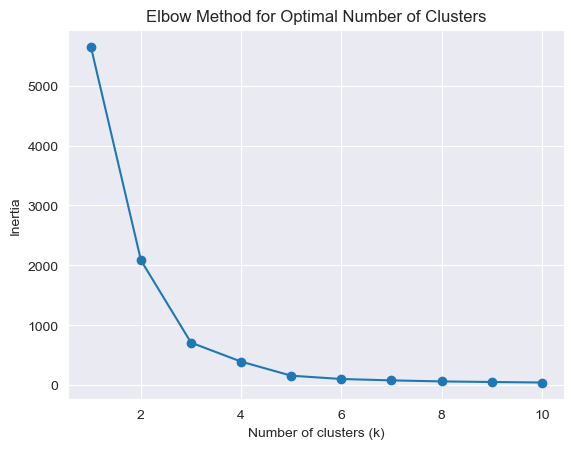

In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming df is your DataFrame with node attributes and edge attributes added

# Convert the DataFrame to a sparse adjacency matrix
#A_dense = pairwise_distances(df_nodes_train.drop(columns=['Node']), metric='euclidean')
A_dense = df_nodes_train_norm[metrics_names]

# Apply Louvain community detection algorithm to detect communities (if needed)
# You may need to find an alternative community detection algorithm for DataFrame-based graphs

# Calculate the modularity for different values of k
k_values = range(1, 11)  # Adjust the range as needed
inertias = []

amount_k = len(k_values)
for k in k_values:
    print(f'{k}/{amount_k}')
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(A_dense)
    inertia = kmeans.inertia_
    inertias.append(inertia)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


In [16]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(A_dense)
    score = silhouette_score(A_dense, kmeans.labels_)
    silhouette_scores.append(score)

best_k = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2
print("Best number of clusters:", best_k)
silhouette_scores

Best number of clusters: 6


[0.6802357457763349,
 0.82632629893162,
 0.8541831762156306,
 0.8862971521543388,
 0.8937857450029649,
 0.8759295089182467,
 0.6623366419733808,
 0.6645589945435495,
 0.6922633777946219]

In [17]:
from sklearn.cluster import KMeans

# Assuming df_nodes_train is your DataFrame containing node attributes

# Extract the features (attributes) from the DataFrame
X = df_nodes_train_norm[metrics_names]

# Specify the number of clusters (k)
#k = best_k  # Adjust as needed
k = 6

# Initialize KMeans model
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels as a new column in the DataFrame
df_nodes_train['Cluster'] = cluster_labels
df_nodes_train_norm['Cluster'] = cluster_labels

# Display the DataFrame with cluster labels
df_nodes_train


,name,betweenesscentrality,closnesscentrality,clustering,degree,eccentricity,eigencentrality,harmonicclosnesscentrality,weighted degree,Spotify ID,Cluster
0,Brazil Beat,0.000000,0.478873,0.000000,1,3,0.128397,16.833333,2,7bcEoznqVIoj6g73gd0bls,0
1,Ella Henderson,0.000537,0.182102,0.000000,4,13,0.000611,1327.372097,8,7nDsS0l5ZAzMedVRKPP8F1,1
2,Motown Moe,0.000000,0.000000,0.000000,0,0,1.000000,0.000000,0,11Zyntp0JZFeb8uyttfNIw,2
3,Caoimhín Ó Raghallaigh,0.000000,1.000000,0.000000,1,1,0.707107,1.000000,2,2w5HzcbBTCyYSWqbmM5UxA,3
4,Bruce Hornsby & The Noisemakers,0.000293,0.142789,0.000000,2,14,0.000002,1022.151141,4,06NImT91wUYvhRqBAYO07m,1
...,...,...,...,...,...,...,...,...,...,...,...
13279,Positive Force,0.000000,0.500000,0.000000,1,3,0.260804,4.333333,2,3AESCWpgSq8ykxcctEQ2mb,0
13280,Tay Beatz,0.000000,0.185976,0.000000,1,14,0.007641,1390.761303,2,71kmbARcZOwkZ6v7lqJaW4,1
13281,Baumon,0.000000,0.520000,0.000000,1,2,0.196116,7.000000,4,6reSddz928YVnAXuLrgFT0,0
13282,Ms. Krazie,0.000000,0.143583,0.000000,1,14,0.000014,1024.981768,2,4dUH7FYUfmPzqS8KA3Ddbs,1


In [18]:
# Assuming df_nodes_train is your DataFrame with cluster labels

# Calculate the cardinality of each cluster
cluster_cardinality = df_nodes_train_norm['Cluster'].value_counts()

# Display the cardinality of each cluster
print(cluster_cardinality)


Cluster
1    6781
2    3403
0    1497
3    1181
4     362
5      60
Name: count, dtype: int64


In [19]:
import pandas as pd

data = [
    ["1A 2A 3A 4A", 0, 0, 0, 0, 0, 0, 0],
    ["1A 2A 3A 4B", 0, 0, 0, 0, 0, 1, 1],
    ["1A 2A 3B 4A", 0, 0, 0, 0, 1, 0, 0],
    ["1A 2A 3B 4B", 0, 0, 0, 0, 1, 1, 1],
    ["1A 2B 3A 4A", 0, 0, 1, 1, 0, 0, 0],
    ["1A 2B 3A 4B", 0, 0, 1, 1, 0, 1, 1],
    ["1A 2B 3B 4A", 0, 0, 1, 1, 1, 0, 0],
    ["1A 2B 3B 4B", 0, 0, 1, 1, 1, 1, 1],
    ["1B 2A 3A 4A", 1, 1, 0, 0, 0, 0, 0],
    ["1B 2A 3A 4B", 1, 1, 0, 0, 0, 1, 1],
    ["1B 2A 3B 4A", 1, 1, 0, 0, 1, 0, 0],
    ["1B 2A 3B 4B", 1, 1, 0, 0, 1, 1, 1],
    ["1B 2B 3A 4A", 1, 1, 1, 1, 0, 0, 0],
    ["1B 2B 3A 4B", 1, 1, 1, 1, 0, 1, 1],
    ["1B 2B 3B 4A", 1, 1, 1, 1, 1, 0, 0],
    ["1B 2B 3B 4B", 1, 1, 1, 1, 1, 1, 1]
]

df = pd.DataFrame(data, columns=["profile", "degree", "weighted degree", "eccentricity", "closnesscentrality", "clustering", "betweenesscentrality", "eigencentrality"])

df

,profile,degree,weighted degree,eccentricity,closnesscentrality,clustering,betweenesscentrality,eigencentrality
0,1A 2A 3A 4A,0,0,0,0,0,0,0
1,1A 2A 3A 4B,0,0,0,0,0,1,1
2,1A 2A 3B 4A,0,0,0,0,1,0,0
3,1A 2A 3B 4B,0,0,0,0,1,1,1
4,1A 2B 3A 4A,0,0,1,1,0,0,0
5,1A 2B 3A 4B,0,0,1,1,0,1,1
6,1A 2B 3B 4A,0,0,1,1,1,0,0
7,1A 2B 3B 4B,0,0,1,1,1,1,1
8,1B 2A 3A 4A,1,1,0,0,0,0,0
9,1B 2A 3A 4B,1,1,0,0,0,1,1


In [20]:
import numpy as np

# Function to calculate Euclidean distance
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

profile = []

common_columns = ["degree", "weighted degree", "eccentricity", "closnesscentrality", "clustering", "betweenesscentrality", "eigencentrality"]

for index, row in df_nodes_train_norm.iterrows():
    match_found = False
    min_dist = np.inf
    min_index = -1

    for index2, prof in df.iterrows():
        # Extract the common columns for the current rows
        radar_row = row[common_columns]
        df_row = prof[common_columns]

        # Calculate the Euclidean distance
        distance = euclidean_distance(radar_row.values, df_row.values)

        if distance < min_dist:
            min_dist = distance
            min_index = index2

    if min_index != -1:
        profile.append(df["profile"].iloc[min_index])
    else:
        profile.append("No Match")

# Insert the 'profile' column into df_nodes_train

df_nodes_train.insert(df_nodes_train.shape[1], 'profile', profile)
df_nodes_train_norm.insert(df_nodes_train_norm.shape[1], 'profile', profile)

df_nodes_train


,name,betweenesscentrality,closnesscentrality,clustering,degree,eccentricity,eigencentrality,harmonicclosnesscentrality,weighted degree,Spotify ID,Cluster,profile
0,Brazil Beat,0.000000,0.478873,0.000000,1,3,0.128397,16.833333,2,7bcEoznqVIoj6g73gd0bls,0,1A 2A 3A 4A
1,Ella Henderson,0.000537,0.182102,0.000000,4,13,0.000611,1327.372097,8,7nDsS0l5ZAzMedVRKPP8F1,1,1A 2A 3A 4A
2,Motown Moe,0.000000,0.000000,0.000000,0,0,1.000000,0.000000,0,11Zyntp0JZFeb8uyttfNIw,2,1A 2A 3A 4A
3,Caoimhín Ó Raghallaigh,0.000000,1.000000,0.000000,1,1,0.707107,1.000000,2,2w5HzcbBTCyYSWqbmM5UxA,3,1A 2B 3A 4A
4,Bruce Hornsby & The Noisemakers,0.000293,0.142789,0.000000,2,14,0.000002,1022.151141,4,06NImT91wUYvhRqBAYO07m,1,1A 2A 3A 4A
...,...,...,...,...,...,...,...,...,...,...,...,...
13279,Positive Force,0.000000,0.500000,0.000000,1,3,0.260804,4.333333,2,3AESCWpgSq8ykxcctEQ2mb,0,1A 2A 3A 4A
13280,Tay Beatz,0.000000,0.185976,0.000000,1,14,0.007641,1390.761303,2,71kmbARcZOwkZ6v7lqJaW4,1,1A 2A 3A 4A
13281,Baumon,0.000000,0.520000,0.000000,1,2,0.196116,7.000000,4,6reSddz928YVnAXuLrgFT0,0,1A 2A 3A 4A
13282,Ms. Krazie,0.000000,0.143583,0.000000,1,14,0.000014,1024.981768,2,4dUH7FYUfmPzqS8KA3Ddbs,1,1A 2A 3A 4A


In [21]:
df_nodes_train.to_csv("network_clustered/nodes_train.csv", index=False)

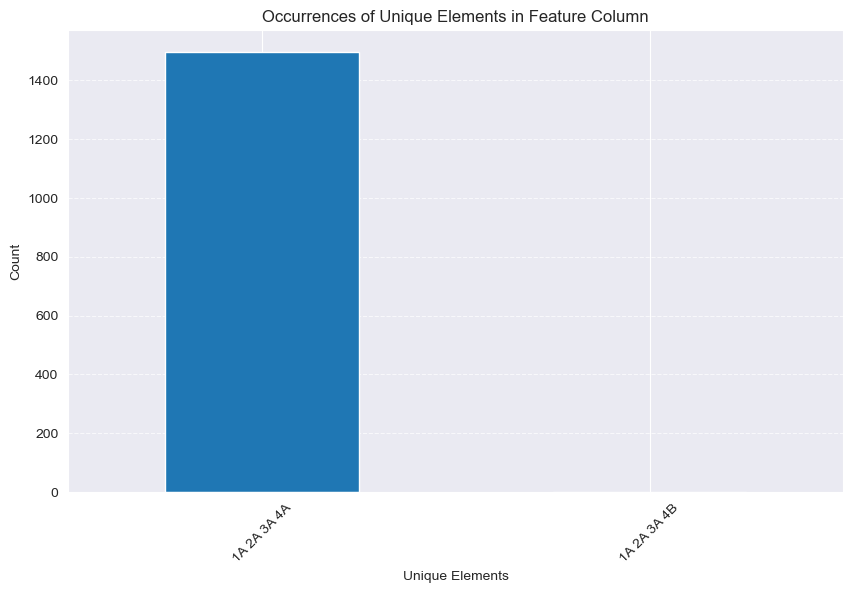

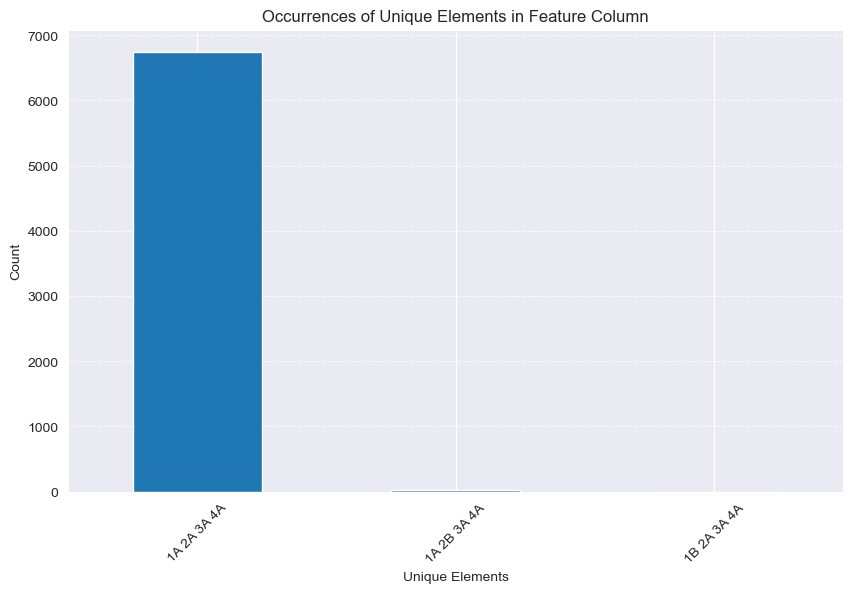

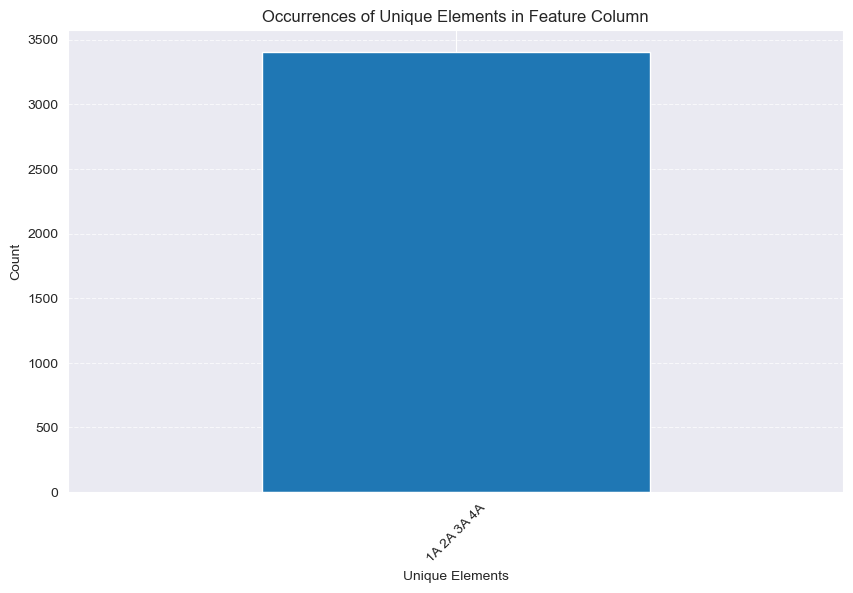

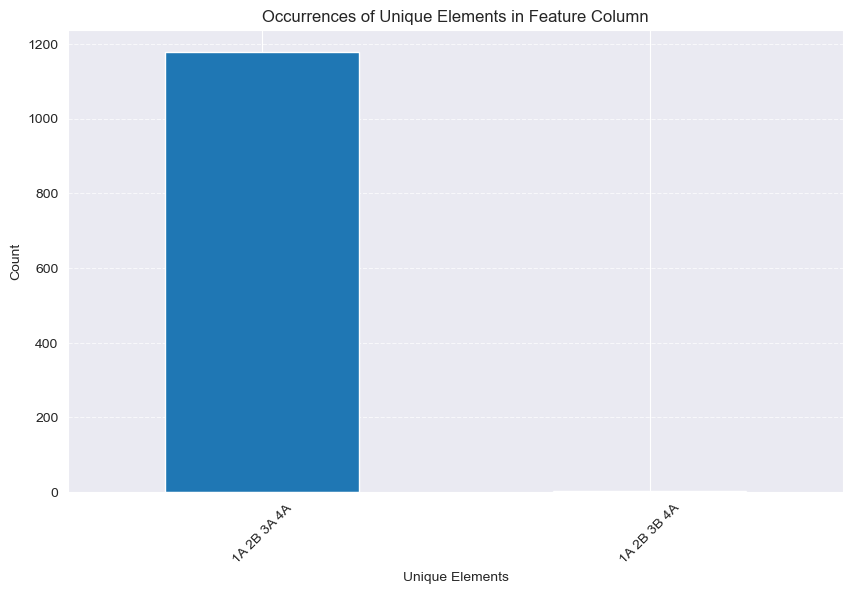

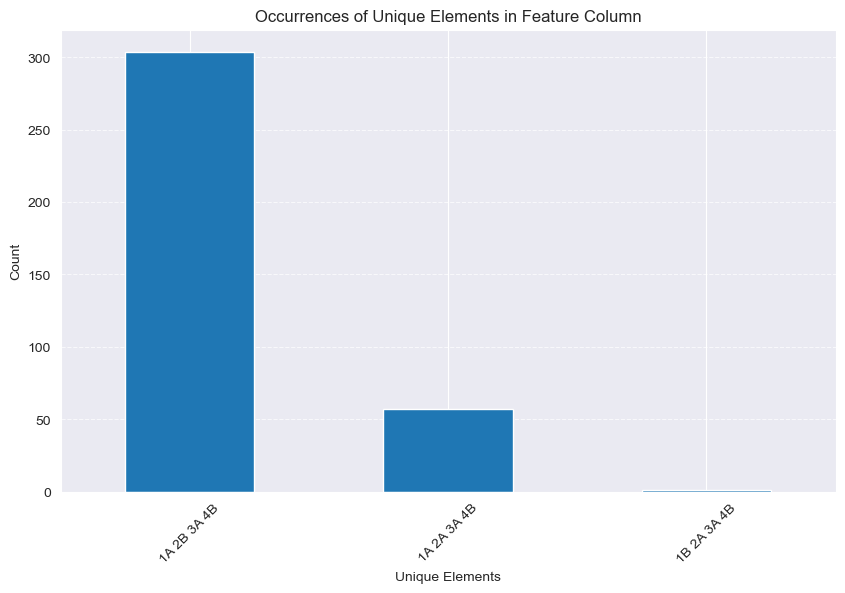

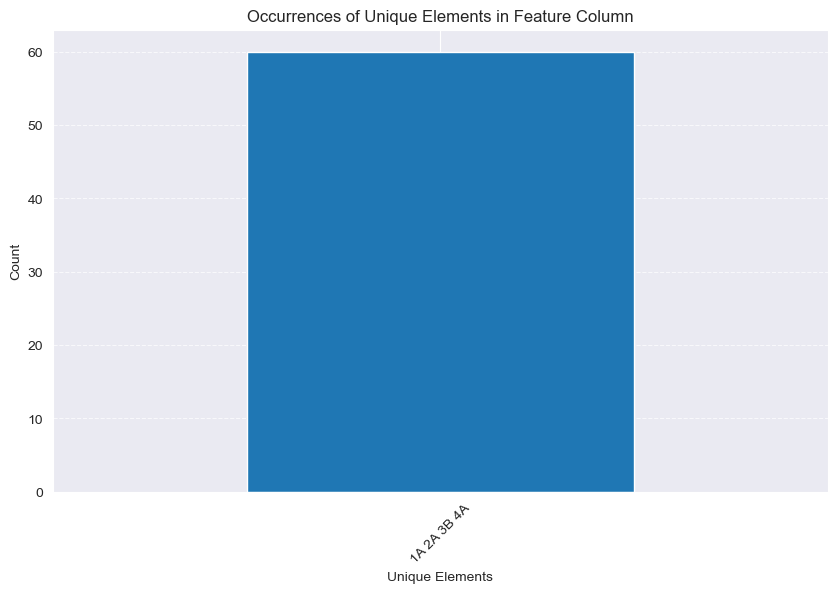

In [22]:
import matplotlib.pyplot as plt

clusters = df_nodes_train["Cluster"].unique()

for i in clusters:

    value_counts = df_nodes_train[df_nodes_train["Cluster"] == i]['profile'].value_counts()

    # Plotting
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar')
    plt.title('Occurrences of Unique Elements in Feature Column')
    plt.xlabel('Unique Elements')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# test:


In [23]:
# Specify the columns
columns = ['artist_id', 'artist_name']

# Initialize an empty DataFrame
df_artists_test = pd.DataFrame(columns={col: [] for col in columns})

count = 0
artist_set = set()

for _, row in test_df.iterrows():
    current_artist_id_list = eval(row["id_artists"])
    current_artist_name_list = eval(row["name_artists"])
    for cur_art_id, cur_art_name in zip(current_artist_id_list, current_artist_name_list):
        if cur_art_id not in artist_set:
            artist_set.add(cur_art_id)
            df_artists_test.loc[len(df_artists_test)] = [cur_art_id, cur_art_name]
            count += 1

print("amount of artists:", count)
df_artists_test

amount of artists: 5902


,artist_id,artist_name
0,0KMJUP87x4ERfwSNYvkttw,Sandgrounder
1,3OpJxAHfT0KsJzQqdX5SLb,Ginger Tunes
2,6BkcAbUkfIBM4XudxieMq8,Dr. Alban
3,2iAAXHZCgL2E1zqj204GEh,Jacci McGhee
4,21VBNkZvKxrI9zmfFRxXvn,8-Bit Arcade
...,...,...
5897,3Y9xnCbmXGhmpJymwpnxCz,Crispian St. Peters
5898,5NDMothbpdpq2xHqSjrrWn,Faith Evans
5899,1Ve5PoI7i5jIIP1xudo6AB,The Parliaments
5900,40PLSl99xXqAQsCQQPmfyM,Kym Sims


In [24]:
#maybe change later
#test_df = test_df[test_df["num_artists"] <= 2]
test_df_cpy = test_df.copy()
test_df_cpy

,song_id,song_name,id_artists,name_artists,popularity,explicit,song_type,track_number,num_artists,num_available_markets,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,hit,date
563810,6R3RXAvtypsoN6jWsjeabw,Nordic Shores,['0KMJUP87x4ERfwSNYvkttw'],['Sandgrounder'],0,False,Solo,5,1,79,...,0.646,0.490,0.895000,0.2230,-16.153,0.0525,0.8420,95.016,0,2018-08-26
563811,2Tb4RA2rzI3Xp97Q3EuhZ6,Wave,['3OpJxAHfT0KsJzQqdX5SLb'],['Ginger Tunes'],0,False,Solo,6,1,79,...,0.668,0.414,0.902000,0.1120,-10.019,0.0361,0.0399,121.084,0,2018-08-26
563812,2ADv9UhiY8pACXvwxP9mr0,Waltz for Joshua,['3OpJxAHfT0KsJzQqdX5SLb'],['Ginger Tunes'],0,False,Solo,7,1,79,...,0.650,0.235,0.887000,0.1490,-12.020,0.0346,0.0391,116.265,0,2018-08-26
641117,2RcAviQBeJrtZDZ7P1Co9k,Elmoped,['6BkcAbUkfIBM4XudxieMq8'],['Dr. Alban'],28,False,Solo,1,1,79,...,0.851,0.568,0.000000,0.1450,-7.159,0.0589,0.4710,119.981,0,2018-08-26
563813,7DnbauUP88t63cDXUrdovz,Black Orpheus,['3OpJxAHfT0KsJzQqdX5SLb'],['Ginger Tunes'],0,False,Solo,8,1,79,...,0.752,0.435,0.901000,0.0886,-10.619,0.0347,0.1250,122.128,0,2018-08-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098,0xAqhyWvTkfcdFgm7dozMO,(I Wanna) Testify (Mono Single Version),['1Ve5PoI7i5jIIP1xudo6AB'],['The Parliaments'],7,False,Solo,10,1,79,...,0.668,0.702,0.000000,0.0521,-5.750,0.0330,0.7540,105.227,1,2019-08-23
10903,6zhg8TnVKi90ITDzFKwPr0,Swingtown - Alternate Version,['6QtGlUje9TIkLrgPZrESuk'],['Steve Miller Band'],26,False,Solo,5,1,79,...,0.459,0.764,0.000544,0.2440,-6.662,0.0354,0.4390,124.557,1,2019-08-23
5856,2GvkFSjRXV0Ii3uYnHiQ74,Take My Advice,['40PLSl99xXqAQsCQQPmfyM'],['Kym Sims'],0,False,Solo,10,1,73,...,0.737,0.814,0.392000,0.0844,-10.396,0.0307,0.8030,120.010,1,2019-08-23
5080,0lej8CemYKkWVHg77Xe1ky,A Man Holdin' on (To a Woman Lettin’ Go),"['1Fj0R2t4HaJa3oUe8azB8R', '5LDnSV99gbDSsMX3Dc...","['Ty Herndon', 'Anita Cochran']",14,False,Collaboration,7,2,79,...,0.611,0.429,0.000014,0.1120,-8.619,0.0298,0.2370,128.007,1,2019-08-23


In [25]:
import networkx as nx

def get_biggest_subgraph(G, specific_nodes):
    """
    Finds the biggest connected subgraph containing all nodes in specific_nodes
  
    Args:
        G: The original NetworkX graph.
        specific_nodes: A set or list of nodes that must be present in the subgraph.
  
    Returns:
        The biggest connected subgraph containing all nodes in specific_nodes, 
        or None if no such subgraph exists.
    """
    largest_subgraph = None
    max_nodes = 0

    for subgraph in nx.connected_components(G):
        # Check if subgraph intersects with specific nodes
        if subgraph & specific_nodes:
            # Update largest subgraph if current one has more nodes
            if len(subgraph) > max_nodes:
                largest_subgraph = subgraph
                max_nodes = len(subgraph)

    subgraph = G.subgraph(largest_subgraph)

    return subgraph

# Example usage
G2 = nx.karate_club_graph()  # Example graph
specific_nodes = {1, 2, 3, 4}  # Nodes you want in the subgraph

biggest_subgraph = get_biggest_subgraph(G2.copy(), specific_nodes)

if biggest_subgraph:
    print("Biggest subgraph containing specific nodes:")
    print(biggest_subgraph.nodes())
    print(biggest_subgraph.edges())
else:
    print("No subgraph containing all specific nodes found")


Biggest subgraph containing specific nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]


In [26]:
import networkx as nx

def subgraph_to_string(subgraph):
    output = "Nodes:\n"
    for node, data in subgraph.nodes(data=True):
        output += f"{node}: {data}\n"

    output += "\nEdges:\n"
    for edge in subgraph.edges(data=True):
        u, v, data = edge
        output += f"{u} -- {v}: {data}\n"

    return output

# Example usage:
G2 = nx.Graph()
G2.add_edge(1, 2, weight=0.5)
G2.add_edge(2, 3, weight=0.75)

sub = G2.subgraph([1, 2, 3])
print(subgraph_to_string(sub))


Nodes:
1: {}
2: {}
3: {}

Edges:
1 -- 2: {'weight': 0.5}
2 -- 3: {'weight': 0.75}


In [27]:
import networkx as nx

def get_nodes_by_id(graph, id_list):
    # Initialize an empty list to store the nodes
    nodes = []

    # Iterate through the nodes of the graph
    for node in graph.nodes(data=True):
        # Check if the node ID is in the list of IDs
        if node[0] in id_list:
            # Append the node to the list
            nodes.append(node)

    return nodes

# Example usage:
# Assuming G is your NetworkX graph and id_list is the list of node IDs

In [28]:
#partially generated loop isn't gen
def largest_subgraph_containing_nodes(graph, node_list):
    # Get all connected components
    connected_components = list(nx.connected_components(graph))

    # Filter components containing all nodes from the given list
    #target_components = [cc for cc in connected_components if set(node_list).issubset(set(cc))]
    
    target_components = []
    for cc in connected_components: 
        all = True
        for id_cur in node_list:
            if not id_cur in cc: 
                all= False
        if all:
            target_components.append(cc)

    #if len(target_components) > 1:
    print(target_components)

    if not target_components:
        return None  # No subgraph contains all the nodes

    # Calculate sizes of target components
    #component_sizes = {cc: len(cc) for cc in target_components}
    max_len = 0
    max_subgraph = None
    for cc  in target_components:
        if len(cc) > max_len:
            max_len = len(cc)
            max_subgraph = cc

    # Get the largest component
    subgraph = graph.subgraph(max_subgraph)

    return subgraph

In [ ]:
import networkx as nx

#df_artist_attributes = pd.DataFrame(columns=["song_id", "artist_id", "name", 'betweenesscentrality', 'closnesscentrality', 'clustering', 
#                                             'degree', 'eccentricity', 'eigencentrality', 'weighted degree'])
storage_list = []
all_artist_ids = artist_set.copy()
iter = 0
tot_len = test_df_cpy.shape[0]
for index, row in test_df_cpy.iterrows():
    G_copy = G.copy()
    
    artist_ids = list(eval(row["id_artists"]))
    artist_names = list(eval(row["name_artists"]))
    # Filter out songs that do not have more than one artist in their execution
    
    #print(G.has_node(artist_ids[0]))
    
    if len(artist_ids) > 1:
        for i in range(len(artist_ids)):
            for j in range(i+1, len(artist_ids)):
                artist_id_1 = str(artist_ids[i])
                lable1 = str(artist_names[i])
                artist_id_2 = str(artist_ids[j])
                lable2 = str(artist_names[j])
                if not G_copy.has_node(artist_id_1):
                    node_attrs = {"name": lable1}
                    G_copy.add_node(artist_id_1, **node_attrs)
                if not G_copy.has_node(artist_id_2):
                    node_attrs = {"name": lable2}
                    G_copy.add_node(artist_id_2, **node_attrs)
                # Check if the edG_copye already exists
                if G_copy.has_edge(artist_id_1, artist_id_2):
                    # If the edge already exists, increment the weight by 1
                    G_copy[artist_id_1][artist_id_2]['weight'] += 2
                else:
                    # Add a new edge with weight 1
                    G_copy.add_edge(artist_id_1, artist_id_2, lable1=lable1, lable2=lable2, weight=2, song_id=str(row["song_id"]), song_name=str(row["song_name"]), explicit=bool(row["explicit"]), song_type=str(row["song_type"]), track_number=int(row["track_number"]), num_artists=int(row["num_artists"]), num_available_markets=int(row["num_available_markets"]), duration_ms=int(row["duration_ms"]), popularity=int(row["popularity"]), release_date=str(row["release_date"]), key = int(row["key"]), mode = int(row["mode"]), time_signature = int(row["time_signature"]), acousticness = float(row["acousticness"]), danceability = float(row["danceability"]), energy = float(row["energy"]), instrumentalness = float(row["instrumentalness"]), liveness = float(row["liveness"]),loudness = float(row["loudness"]), speechiness = float(row["speechiness"]), valence = float(row["valence"]), tempo = float(row["tempo"]))
    else:
        #prüfe ob die Artists Teil der Interessanten Menge sind
        artist_id_1 = str(artist_ids[0])
        lable1 = str(artist_names[0])
        if not G_copy.has_node(artist_id_1):
            node_attrs = {"name": lable1}
            G_copy.add_node(artist_id_1, **node_attrs)
        if G_copy.has_edge(artist_id_1, artist_id_1):
            # If the edge already exists, increment the weight by 1
            G_copy[artist_id_1][artist_id_1]['weight'] += 2
        else:
            G_copy.add_edge(artist_id_1, artist_id_1, lable1=lable1, lable2=lable1, weight=2, song_id=str(row["song_id"]), song_name=str(row["song_name"]), explicit=bool(row["explicit"]), song_type=str(row["song_type"]), track_number=int(row["track_number"]), num_artists=int(row["num_artists"]), num_available_markets=int(row["num_available_markets"]), duration_ms=int(row["duration_ms"]), popularity=int(row["popularity"]), release_date=str(row["release_date"]), key = int(row["key"]), mode = int(row["mode"]), time_signature = int(row["time_signature"]), acousticness = float(row["acousticness"]), danceability = float(row["danceability"]), energy = float(row["energy"]), instrumentalness = float(row["instrumentalness"]), liveness = float(row["liveness"]),loudness = float(row["loudness"]), speechiness = float(row["speechiness"]), valence = float(row["valence"]), tempo = float(row["tempo"]))
    
    #calc metrics for song and store it
    # Calculate metrics for subgraphs containing desired nodes
    betweenness_centrality = {}
    closeness_centrality = {}
    clustering = {}
    degree = {}
    eccentricity = {}
    eigenvector_centrality = {}
    harmonic_closeness_centrality = {}
    weighted_degree = {}

    #node_list = get_nodes_by_id(G_copy, artist_ids)
    #subgraph = largest_subgraph_containing_nodes(G_copy, artist_ids)
    subgraph = get_biggest_subgraph(G_copy, set(artist_ids))
    #print(subgraph)
    #if len(subgraph) > 2: print(len(subgraph))
    print(len(subgraph))
    # Get all connected components
    #connected_components = nx.connected_components(G_copy)
    
    # Iterate over connected components
    #for cc in connected_components:
        # Create a subgraph containing only the desired nodes
        #subgraph = G_copy.subgraph(cc).copy()
    if all(artist_id in subgraph for artist_id in artist_ids):
        #print("####Metrics Calc####")
        #if len(subgraph) >= 3: print(subgraph_to_string(subgraph))
        # Calculate metrics for this subgraph
        betweenness_centrality = nx.betweenness_centrality(subgraph)
        closeness_centrality = nx.closeness_centrality(subgraph)
        clustering = nx.clustering(subgraph)
        degree = nx.degree(subgraph)
        eccentricity = nx.eccentricity(subgraph)
        eigenvector_centrality = nx.eigenvector_centrality(subgraph)
        harmonic_closeness_centrality = nx.harmonic_centrality(subgraph)
        weighted_degree = nx.degree(subgraph, weight='weight')
        """betweenness_centrality.update(nx.betweenness_centrality(subgraph))
        closeness_centrality.update(nx.closeness_centrality(subgraph))
        clustering.update(nx.clustering(subgraph))
        degree.update(nx.degree(subgraph))
        eccentricity.update(nx.eccentricity(subgraph))
        eigenvector_centrality.update(nx.eigenvector_centrality(subgraph))
        harmonic_closeness_centrality.update(nx.harmonic_centrality(subgraph))
        weighted_degree.update(nx.degree(subgraph, weight='weight'))"""

    #print("next")
    for curr_artist_id in artist_ids:
        #print(curr_artist_id)
        if G_copy.has_node(curr_artist_id):
            artist_attributes = G_copy.nodes[curr_artist_id]
            #print(artist_attributes.keys())
            # Append the artist ID and attributes to the DataFramen
            #attrib = pd.DataFrame({"song_id": row["song_id"], "artist_id": curr_artist_id, "name": artist_attributes["name"], 'betweenesscentrality': artist_attributes['betweenesscentrality'], 'closnesscentrality': artist_attributes['closnesscentrality'], 'clustering': artist_attributes['clustering'], 'degree': artist_attributes["degree"], 'eccentricity': artist_attributes["eccentricity"], 'eigencentrality': artist_attributes['eigencentrality'], 'weighted degree': artist_attributes['weighted degree']}, index=[0])
            #print(clustering[artist_ids])
            storage_list.append([row["song_id"], curr_artist_id, artist_attributes["name"], betweenness_centrality[curr_artist_id], closeness_centrality[curr_artist_id], clustering[curr_artist_id], degree[curr_artist_id], eccentricity[curr_artist_id], eigenvector_centrality[curr_artist_id], weighted_degree[curr_artist_id]])
            #print(attrib)
    
    iter += 1
    print(f"{iter}/{tot_len}")
#df_artist_attributes = pd.concat([df_artist_attributes, attrib], axis=0)

1
next
1
next
1
next
2
next
1
next
6836
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
35
next
1
next
8
next
3
next
1
next
35
next
1
next
8
next
3
next
1
next
3
next
8
next
1
next
8
next
3
next
1
next
8
next
3
next
1
next
8
next
3
next
1
next
3
next
1
next
1
next
35
next
35
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
1
next
8
next
1
next
1
next
35
next
35
next
35
next
1
next
1
next
1
next
8
next
3
next
1
next
8
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
1
next
1
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next
35
next


In [ ]:
len(storage_list)

In [ ]:
# Define the columns for the DataFrame
columns = ["song_id", "artist_id", "name", 'betweenesscentrality', 'closnesscentrality', 'clustering', 'degree', 'eccentricity', 'eigencentrality', 'weighted degree']

# Create the DataFrame from storage_list
df_artist_attributes = pd.DataFrame(storage_list, columns=columns)

# Print the DataFrame
df_artist_attributes


In [ ]:
#df_artist_attributes[df_artist_attributes["artist_id"] == "6eUKZXaKkcviH0Ku9w2n3V"]
df_artist_attributes["artist_id"].nunique()

In [ ]:
df_artist_attributes[df_artist_attributes["artist_id"] == "6eUKZXaKkcviH0Ku9w2n3V"]

In [ ]:
df_nodes_test = df_artist_attributes.copy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

metrics_names = ['betweenesscentrality',
                 'closnesscentrality',
                 'clustering',
                 'degree',
                 'eccentricity',
                 'eigencentrality',
                 'weighted degree']

# Assuming df_nodes_test is your DataFrame
# Select only the columns to be normalized
columns_to_normalize = metrics_names  # Exclude the first and last columns
data_to_normalize = df_nodes_test[columns_to_normalize]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(data_to_normalize)

# Replace the original data with the normalized values
df_nodes_test_norm = df_nodes_test.copy()
df_nodes_test_norm[columns_to_normalize] = normalized_data

# Print the updated DataFrame
df_nodes_test_norm

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming df is your DataFrame with node attributes and edge attributes added

# Convert the DataFrame to a sparse adjacency matrix
#A_dense = pairwise_distances(df_nodes_test.drop(columns=['Node']), metric='euclidean')
A_dense = df_nodes_test_norm[metrics_names]

# Apply Louvain community detection algorithm to detect communities (if needed)
# You may need to find an alternative community detection algorithm for DataFrame-based graphs

# Calculate the modularity for different values of k
k_values = range(1, 11)  # Adjust the range as needed
inertias = []

amount_k = len(k_values)
for k in k_values:
    print(f'{k}/{amount_k}')
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(A_dense)
    inertia = kmeans.inertia_
    inertias.append(inertia)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(A_dense)
    score = silhouette_score(A_dense, kmeans.labels_)
    silhouette_scores.append(score)

best_k = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2
print("Best number of clusters:", best_k)
silhouette_scores

In [ ]:
from sklearn.cluster import KMeans

# Assuming df_nodes_test is your DataFrame containing node attributes

# Extract the features (attributes) from the DataFrame
X = df_nodes_test_norm[metrics_names]

# Specify the number of clusters (k)
#k = best_k  # Adjust as needed
k = 6

# Initialize KMeans model
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels as a new column in the DataFrame
df_nodes_test['Cluster'] = cluster_labels
df_nodes_test_norm['Cluster'] = cluster_labels

# Display the DataFrame with cluster labels
df_nodes_test


In [ ]:
# Assuming df_nodes_test is your DataFrame with cluster labels

# Calculate the cardinality of each cluster
cluster_cardinality = df_nodes_test_norm['Cluster'].value_counts()

# Display the cardinality of each cluster
print(cluster_cardinality)


In [ ]:
import pandas as pd

data = [
    ["1A 2A 3A 4A", 0, 0, 0, 0, 0, 0, 0],
    ["1A 2A 3A 4B", 0, 0, 0, 0, 0, 1, 1],
    ["1A 2A 3B 4A", 0, 0, 0, 0, 1, 0, 0],
    ["1A 2A 3B 4B", 0, 0, 0, 0, 1, 1, 1],
    ["1A 2B 3A 4A", 0, 0, 1, 1, 0, 0, 0],
    ["1A 2B 3A 4B", 0, 0, 1, 1, 0, 1, 1],
    ["1A 2B 3B 4A", 0, 0, 1, 1, 1, 0, 0],
    ["1A 2B 3B 4B", 0, 0, 1, 1, 1, 1, 1],
    ["1B 2A 3A 4A", 1, 1, 0, 0, 0, 0, 0],
    ["1B 2A 3A 4B", 1, 1, 0, 0, 0, 1, 1],
    ["1B 2A 3B 4A", 1, 1, 0, 0, 1, 0, 0],
    ["1B 2A 3B 4B", 1, 1, 0, 0, 1, 1, 1],
    ["1B 2B 3A 4A", 1, 1, 1, 1, 0, 0, 0],
    ["1B 2B 3A 4B", 1, 1, 1, 1, 0, 1, 1],
    ["1B 2B 3B 4A", 1, 1, 1, 1, 1, 0, 0],
    ["1B 2B 3B 4B", 1, 1, 1, 1, 1, 1, 1]
]

df = pd.DataFrame(data, columns=["profile", "degree", "weighted degree", "eccentricity", "closnesscentrality", "clustering", "betweenesscentrality", "eigencentrality"])

df

In [ ]:
import numpy as np

# Function to calculate Euclidean distance
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

profile = []

common_columns = ["degree", "weighted degree", "eccentricity", "closnesscentrality", "clustering", "betweenesscentrality", "eigencentrality"]

for index, row in df_nodes_test_norm.iterrows():
    match_found = False
    min_dist = np.inf
    min_index = -1

    for index2, prof in df.iterrows():
        # Extract the common columns for the current rows
        radar_row = row[common_columns]
        df_row = prof[common_columns]

        # Calculate the Euclidean distance
        distance = euclidean_distance(radar_row.values, df_row.values)

        if distance < min_dist:
            min_dist = distance
            min_index = index2

    if min_index != -1:
        profile.append(df["profile"].iloc[min_index])
    else:
        profile.append("No Match")

# Insert the 'profile' column into df_nodes_test

df_nodes_test.insert(df_nodes_test.shape[1], 'profile', profile)
df_nodes_test_norm.insert(df_nodes_test_norm.shape[1], 'profile', profile)

df_nodes_test


In [ ]:
import matplotlib.pyplot as plt

clusters = df_nodes_test["Cluster"].unique()

for i in clusters:

    value_counts = df_nodes_test[df_nodes_test["Cluster"] == i]['profile'].value_counts()

    # Plotting
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar')
    plt.title('Occurrences of Unique Elements in Feature Column')
    plt.xlabel('Unique Elements')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
#df_nodes_test.to_csv("network_clustered/nodes_test_lol.csv", index=False)

In [ ]:
mdosfos

In [ ]:
# Assuming G is your NetworkX graph

# Extract nodes and their attributes from the graph
nodes_with_attributes = [(G.nodes[node], node) for node in G.nodes()]

# Create a DataFrame from the nodes and their attributes
df_nodes_train = pd.DataFrame(nodes_with_attributes, columns=['Attributes', "Spotify ID"])

# Normalize the 'Attributes' column to expand it into separate columns
df_attributes = pd.json_normalize(df_nodes_train['Attributes'])

# Combine the original 'Node' column with the expanded attributes
df_nodes_train = pd.concat([df_attributes, df_nodes_train['Spotify ID']], axis=1)

# Display the DataFrame
df_nodes_train

In [ ]:
df_nodes_train.to_csv("network_created/nodes_real_train.csv", sep='\t', index=False)

In [ ]:
# Extract edges and their attributes from the graph
edges_with_attributes = [(u, v, G.edges[u, v]) for u, v in G.edges()]

# Create a DataFrame from the edges and their attributes
df_edges_train = pd.DataFrame(edges_with_attributes, columns=['Source', 'Target', 'Attributes'])

# Normalize the 'Attributes' column to expand it into separate columns
df_edge_attributes = pd.json_normalize(df_edges_train['Attributes'])

# Combine the original 'Attributes' column with the expanded attributes
df_edges_train = pd.concat([df_edges_train[['Source', 'Target']], df_edge_attributes], axis=1)
df_edges_train

In [ ]:
# Save edge DataFrame to CSV
df_edges_train.to_csv('network_created/edges_real_train.csv', sep='\t', index=False)

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)


In [ ]:
# Specify the columns
columns = ['artist_id', 'artist_name']

# Initialize an empty DataFrame
df_artists_test = pd.DataFrame(columns={col: [] for col in columns})

count = 0
artist_set = set()

for _, row in test_df.iterrows():
    current_artist_id_list = eval(row["id_artists"])
    current_artist_name_list = eval(row["name_artists"])
    for cur_art_id, cur_art_name in zip(current_artist_id_list, current_artist_name_list):
        if cur_art_id not in artist_set:
            artist_set.add(cur_art_id)
            df_artists_test.loc[len(df_artists_test)] = [cur_art_id, cur_art_name]
            count += 1

print("amount of artists:", count)
df_artists_test

In [ ]:
import networkx as nx

all_artist_ids = artist_set.copy()

G2 = nx.Graph()

for id_art_cur in all_artist_ids:
    artist_name = df_artists_test[(df_artists_test["artist_id"] == id_art_cur)]["artist_name"]
    artist_info = df_artists_test[df_artists_test["artist_id"] == id_art_cur]
    if not artist_info.empty:  # Check if artist info exists
        # Filter out artists who are not successful
        node_attrs = {"name": artist_name.iloc[0]}
        G2.add_node(id_art_cur, **node_attrs)
    else:
        print("Artist info not found for ID:", id_art_cur)

for _, row in test_df.iterrows():
    artist_ids = list(eval(row["id_artists"]))
    artist_names = list(eval(row["name_artists"]))
    # Filter out songs that do not have more than one artist in their execution
    if len(artist_ids) > 1:
        for i in range(len(artist_ids)):
            for j in range(i+1, len(artist_ids)):
                artist_id_1 = str(artist_ids[i])
                lable1 = str(artist_names[i])
                artist_id_2 = str(artist_ids[j])
                lable2 = str(artist_names[j])
                # Check if the edge already exists
                if G2.has_edge(artist_id_1, artist_id_2):
                    # If the edge already exists, increment the weight by 1
                    G2[artist_id_1][artist_id_2]['weight'] += 2
                else:
                    # Add a new edge with weight 1
                    G2.add_edge(artist_id_1, artist_id_2, lable1=lable1, lable2=lable2, weight=2, song_id=str(row["song_id"]), song_name=str(row["song_name"]), explicit=bool(row["explicit"]), song_type=str(row["song_type"]), track_number=int(row["track_number"]), num_artists=int(row["num_artists"]), num_available_markets=int(row["num_available_markets"]), duration_ms=int(row["duration_ms"]), popularity=int(row["popularity"]), release_date=str(row["release_date"]), key = int(row["key"]), mode = int(row["mode"]), time_signature = int(row["time_signature"]), acousticness = float(row["acousticness"]), danceability = float(row["danceability"]), energy = float(row["energy"]), instrumentalness = float(row["instrumentalness"]), liveness = float(row["liveness"]),loudness = float(row["loudness"]), speechiness = float(row["speechiness"]), valence = float(row["valence"]), tempo = float(row["tempo"]))

In [ ]:
# Assuming G is your NetworkX graph

# Extract nodes and their attributes from the graph
nodes_with_attributes = [(G2.nodes[node], node) for node in G2.nodes()]

# Create a DataFrame from the nodes and their attributes
df_nodes_test = pd.DataFrame(nodes_with_attributes, columns=['Attributes', "Spotify ID"])

# Normalize the 'Attributes' column to expand it into separate columns
df_attributes = pd.json_normalize(df_nodes_test['Attributes'])

# Combine the original 'Node' column with the expanded attributes
df_nodes_test = pd.concat([df_attributes, df_nodes_test['Spotify ID']], axis=1)

# Display the DataFrame
df_nodes_test

In [ ]:
df_nodes_test.to_csv("network_created/nodes_real_test.csv", sep='\t', index=False)

In [ ]:
# Extract edges and their attributes from the graph
edges_with_attributes = [(u, v, G2.edges[u, v]) for u, v in G2.edges()]

# Create a DataFrame from the edges and their attributes
df_edges_test = pd.DataFrame(edges_with_attributes, columns=['Source', 'Target', 'Attributes'])

# Normalize the 'Attributes' column to expand it into separate columns
df_edge_attributes = pd.json_normalize(df_edges_test['Attributes'])

# Combine the original 'Attributes' column with the expanded attributes
df_edges_test = pd.concat([df_edges_test[['Source', 'Target']], df_edge_attributes], axis=1)
df_edges_test

In [ ]:
# Save edge DataFrame to CSV
df_edges_test.to_csv('network_created/edges_real_test.csv', sep='\t', index=False)

In [ ]:
num_nodes = G2.number_of_nodes()
num_edges = G2.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)


In [ ]:
train_df

In [ ]:
test_df